In [1]:
#import torch
import torch
from torch import nn

#inport torchvision
import torchvision
from torchvision import models
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.nn import functional as F
from torch.utils.data import Dataset

# import matplotlib

import matplotlib.pyplot as plt
import os
from PIL import Image

In [2]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [4]:
transform  = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean = [0.485,0.456,0.406], std = ([0.229,0.224,0.225])),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomCrop(64),
                                 transforms.RandomResizedCrop(size = 224,scale=(0.5,1))])


In [5]:
train_data_path = "//kaggle//input//intel-image-classification//seg_train//seg_train"
test_data_path = "//kaggle//input//intel-image-classification//seg_test//seg_test"

In [6]:
train_dataset = datasets.ImageFolder(root = train_data_path, transform = transform)
test_dataset = datasets.ImageFolder(root = test_data_path, transform = transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = True)

Label:  buildings (0)


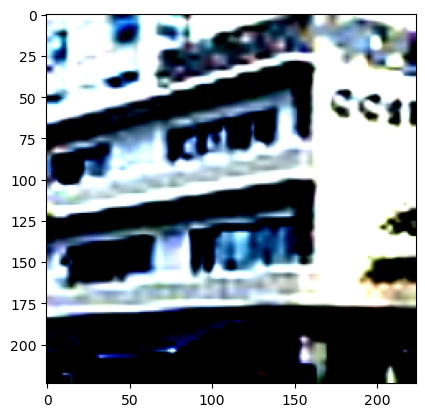

In [8]:
def show_example(img, label):
    print('Label: ', train_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

image , label  = train_dataset[6]
show_example(*train_dataset[6])

Label:  buildings (0)


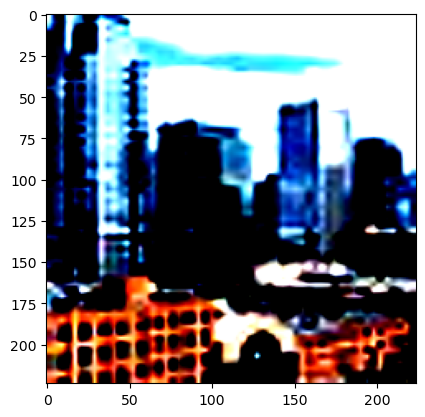

In [9]:

image , label  = train_dataset[1]
show_example(*train_dataset[1])

In [11]:
classes = train_dataset.classes
classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [10]:
model = models.densenet121(pretrained=False)
model.classifier.out_features = 6
model.to(device=device)


/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [13]:
def model_train(epochs, model, train_dataloader, val_dataloader, loss_func, optimizer,scheduler):

    # turn on training mode
    model.train()

    #check training device
    print(f"Training on {device}.")

    # loop through each epoch
    for epoch in range(epochs):
        print(f"Epoch: {epoch + 1}/{epochs}\n-------------")

        # loop through each batch
        train_loss, train_acc = 0, 0
        total_steps = 1
        for images, classes in train_dataloader:

            #send data to device
            images, classes = images.to(device), classes.to(device)

            # computer forward pass
            y_pred = model(images)

            # compute loss
            loss = loss_func(y_pred, classes)
            train_loss += loss
            train_acc += accuracy_fn(y_true = classes, y_pred = y_pred.argmax(dim=1))

            # update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss = train_loss / total_steps
            batch_acc = train_acc / total_steps

            if total_steps % 10 == 0:
                print(f"Training Loss: {batch_loss:.5f} - Training Accuracy: {batch_acc:.5f}%")

            total_steps += 1

        # learning rate decay
        scheduler.step()


        # performance on test set
        # turn on inference mode
        with torch.inference_mode():
            # loop through each batch
            total_val_loss, val_acc = 0, 0
            for val_images, val_classes in val_dataloader:
                # send data to device
                val_images, val_classes = val_images.to(device), val_classes.to(device)

                # forward pass
                y_val_pred = model(val_images)

                # compute loss
                val_loss = loss_func(y_val_pred, val_classes)
                total_val_loss += val_loss
                val_acc += accuracy_fn(y_true = val_classes, y_pred = y_val_pred.argmax(dim=1)
                )
            
            total_val_loss /= len(val_dataloader)
            val_acc /= len(val_dataloader)


        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)

        print(f"[After {epoch + 1} epochs: Train Loss: {train_loss:.5f} - Train Accuracy: {train_acc:.5f}% - Validation Loss: {total_val_loss:.5f} - Validation Accuracy: {val_acc:.5f}%]")

        
        train_loss_values.append(train_loss.item())
        val_loss_values.append(total_val_loss.item())
        val_acc_values.append(val_acc)
        epoch_count.append(epoch + 1)

In [14]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [15]:
train_loss_values = []
val_loss_values = []
val_acc_values = []
epoch_count = []

In [17]:
lr = 0.001

loss_func = nn.CrossEntropyLoss()

Wadam = torch.optim.AdamW(params = model.parameters(), lr = lr,weight_decay = 0.0001)

learning_decay = torch.optim.lr_scheduler.StepLR(optimizer = Radam, step_size = 30, gamma = 0.1)

In [18]:
torch.manual_seed(42)
model_train(epochs = 25, model = model, train_dataloader = train_dataloader, val_dataloader = test_dataloader, loss_func = loss_func, optimizer = Wadam, scheduler = learning_decay)


Training on cuda.
Epoch: 1/25
-------------
Training Loss: 3.82730 - Training Accuracy: 29.68750%
Training Loss: 2.78707 - Training Accuracy: 30.46875%
Training Loss: 2.36033 - Training Accuracy: 32.39583%
Training Loss: 2.16762 - Training Accuracy: 34.14062%
Training Loss: 2.01977 - Training Accuracy: 34.81250%
Training Loss: 1.91768 - Training Accuracy: 36.04167%
Training Loss: 1.84027 - Training Accuracy: 37.27679%
Training Loss: 1.77243 - Training Accuracy: 38.28125%
Training Loss: 1.71806 - Training Accuracy: 38.95833%
Training Loss: 1.68090 - Training Accuracy: 39.65625%
Training Loss: 1.64952 - Training Accuracy: 40.14205%
Training Loss: 1.61803 - Training Accuracy: 40.59896%
Training Loss: 1.58490 - Training Accuracy: 41.29808%
Training Loss: 1.55633 - Training Accuracy: 42.14286%
Training Loss: 1.53815 - Training Accuracy: 42.56250%
Training Loss: 1.52920 - Training Accuracy: 42.42188%
Training Loss: 1.51719 - Training Accuracy: 42.44485%
Training Loss: 1.50512 - Training Accu

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[After 1 epochs: Train Loss: 1.31868 - Train Accuracy: 48.86421% - Validation Loss: 1.09561 - Validation Accuracy: 57.07004%]
Epoch: 2/25
-------------
Training Loss: 1.23869 - Training Accuracy: 49.68750%
Training Loss: 1.20534 - Training Accuracy: 51.40625%
Training Loss: 1.20964 - Training Accuracy: 51.77083%
Training Loss: 1.19467 - Training Accuracy: 51.17188%
Training Loss: 1.16098 - Training Accuracy: 52.62500%
Training Loss: 1.14314 - Training Accuracy: 53.33333%
Training Loss: 1.12848 - Training Accuracy: 54.59821%
Training Loss: 1.13160 - Training Accuracy: 54.45312%
Training Loss: 1.12020 - Training Accuracy: 55.13889%
Training Loss: 1.11968 - Training Accuracy: 55.15625%
Training Loss: 1.11759 - Training Accuracy: 55.05682%
Training Loss: 1.11332 - Training Accuracy: 55.07812%
Training Loss: 1.10923 - Training Accuracy: 55.50481%
Training Loss: 1.10826 - Training Accuracy: 55.42411%
Training Loss: 1.11289 - Training Accuracy: 55.27083%
Training Loss: 1.11506 - Training Accu

In [19]:
test_folder = '//kaggle//input//intel-image-classification//seg_pred//seg_pred'

In [50]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = (img.unsqueeze(0)).to(device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return test_dataset.classes[preds[0].item()]

Label: glacier , Predicted: glacier


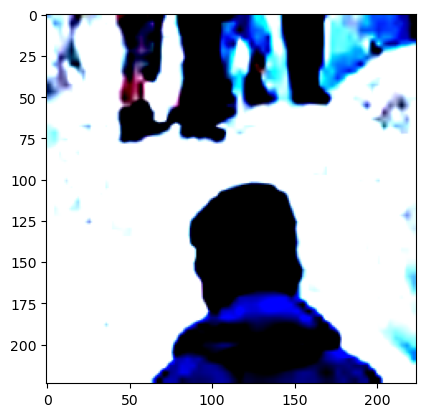

In [53]:
img, label = test_dataset[1000]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

In [20]:
transform1  = transforms.Compose([
                                 transforms.ToTensor(),
                                 ])


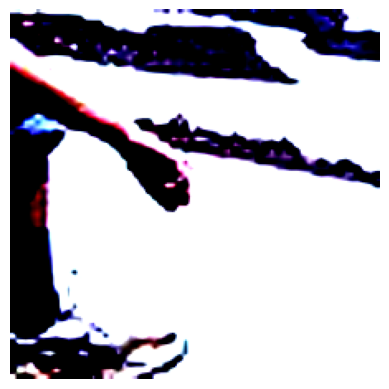

In [43]:
plt.imshow(test_image_tensor.permute(1,2,0))
plt.axis(False)
plt.title
plt.show()

In [59]:
test_image_path = '/kaggle/input/intel-image-classification/seg_pred/seg_pred/10048.jpg'

test_image = Image.open(test_image_path)
test_image_tensor = transform(test_image)
test_image_tensor = test_image_tensor.unsqueeze(0).to('cuda')

test_image_label = model(test_image_tensor)


In [60]:
test_image_label.squeeze(0).shape

torch.Size([1000])

In [61]:
idx = torch.argmax(test_image_label)

In [62]:
train_dataset.classes[int(idx)]

'buildings'